In [1]:
!pip install sodapy

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
from matplotlib.colors import LogNorm

# Data loading and initial viewing

In [3]:
client = Socrata("data.cityofchicago.org", None)
results = client.get("ygr5-vcbg", limit=5000) # Connect to Chicago data API to fetch data

# Convert to pandas DataFrame
dfOriginal = pd.DataFrame.from_records(results)
print("Total rows: "+ str(len(dfOriginal)))
dfOriginal.head()

Total rows: 3114


,tow_date,make,style,color,state,towed_to_address,tow_facility_phone,inventory_number,plate,model
0,2023-10-13T00:00:00.000,ACUR,4D,GRY,IL,10300 S. Doty,(773) 785-9752,1725449,NaN,NaN
1,2023-10-13T00:00:00.000,ACUR,LL,BLK,IL,10300 S. Doty,(773) 568-8495,2957667,ED99921,NaN
2,2023-10-13T00:00:00.000,AUDI,4D,BLU,IL,701 N. Sacramento,(773) 265-7605,7071484,EC70030,NaN
3,2023-10-13T00:00:00.000,AUDI,LL,BLK,IL,701 N. Sacramento,(773) 265-7605,7071508,DG48062,NaN
4,2023-10-13T00:00:00.000,BMW,2T,RED,IL,10300 S. Doty,(773) 568-8495,2957674,BZ33056,NaN


In [4]:
# Count total missing values at each column in the DataFrame
print(" \nCount total NaN at each column in the DataFrame : \n\n",
      dfOriginal.isnull().sum())

 
Count total NaN at each column in the DataFrame : 

 tow_date                 0
make                    56
style                   10
color                   11
state                   80
towed_to_address         0
tow_facility_phone       0
inventory_number         0
plate                  644
model                 2965
dtype: int64


There is a spatial component to the data, namely the towed_to_address column, and the state of vehicle origin as well to a lesser extent. The temporal component consists of the data column.

# Unique category counts for categorical columns
(which are all of them essentially)

In [5]:
dfOriginal.describe()

,tow_date,make,style,color,state,towed_to_address,tow_facility_phone,inventory_number,plate,model
count,3114,3058,3104,3103,3034,3114,3114,3114,2470,149
unique,91,74,34,22,38,4,6,3109,2467,35
top,2023-10-13T00:00:00.000,CHEV,4D,BLK,IL,701 N. Sacramento,(773) 265-7605,1725394,BZ19472,TK
freq,160,369,1550,692,2655,1477,1225,2,2,73


# Data cleaning

In [6]:
dff = dfOriginal.drop('model', axis=1) # Drop model column since a very large proportion of the data doesn't have one
dff.dropna(inplace=True) # Drop any remaining rows with missing data

df = dff
df['tow_date'] = pd.to_datetime(df['tow_date']) # convert tow_date to datetime object
print("Total rows: "+ str(len(df)))
df.head()

Total rows: 2448


,tow_date,make,style,color,state,towed_to_address,tow_facility_phone,inventory_number,plate
1,2023-10-13,ACUR,LL,BLK,IL,10300 S. Doty,(773) 568-8495,2957667,ED99921
2,2023-10-13,AUDI,4D,BLU,IL,701 N. Sacramento,(773) 265-7605,7071484,EC70030
3,2023-10-13,AUDI,LL,BLK,IL,701 N. Sacramento,(773) 265-7605,7071508,DG48062
4,2023-10-13,BMW,2T,RED,IL,10300 S. Doty,(773) 568-8495,2957674,BZ33056
5,2023-10-13,BMW,4D,GRY,IL,701 N. Sacramento,(773) 265-7605,7071485,CZ97580


# Visualization 1

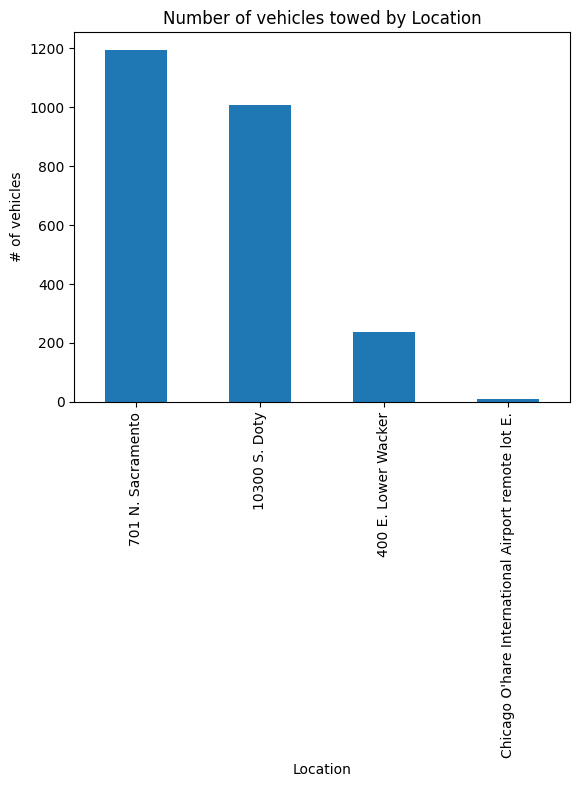

In [7]:
df_make = df['towed_to_address'].value_counts()
df_make.plot(kind='bar')
plt.title("Number of vehicles towed by Location")
plt.ylabel("# of vehicles")
plt.xlabel("Location")
plt.show()

Looking at this bar chart, we can see that the 701 N. Sacremento had the highest amount of cars towed out of any location with 10300 S. Doty Coming in at a close second.

# Visualization 2

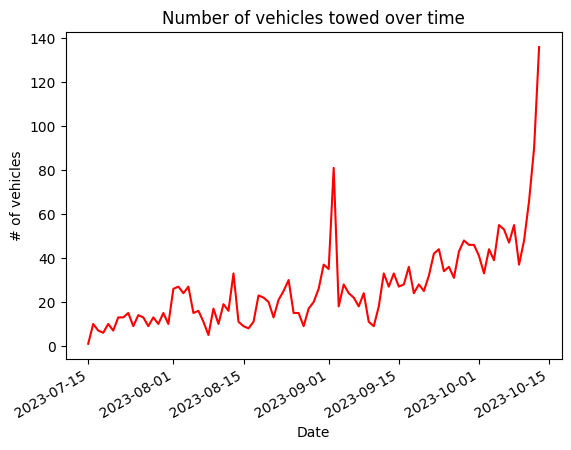

In [8]:
df_time = df['tow_date'].value_counts()
df_time.plot(color = 'red')
plt.title("Number of vehicles towed over time")
plt.ylabel("# of vehicles")
plt.xlabel("Date")
plt.show()

We can see from this line graph that the amount of cars towed steadily increased in the span of 3 months. We can see some spikes in the graph in mid september, maybe due to Labor Day Weekend. There is also a spike at the end of October, maybe due to any Halloween events held.

# Visualization 3

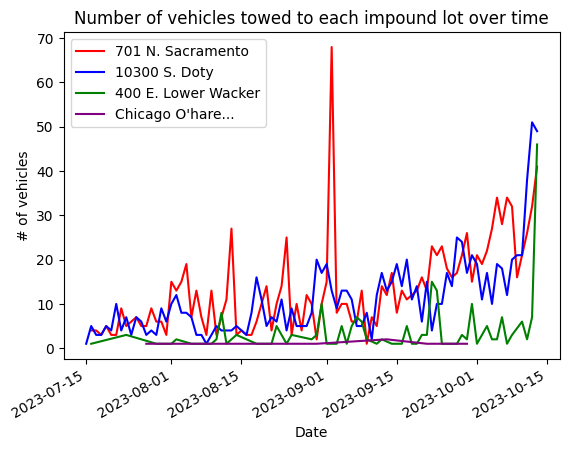

In [9]:
sacremento_df = df[df['towed_to_address'] == '701 N. Sacramento']
doty_df = df[df['towed_to_address'] == '10300 S. Doty']
wacker_df = df[df['towed_to_address'] == '400 E. Lower Wacker']
air_df = df[df['towed_to_address'] == "Chicago O'hare International Airport remote lot E."]
sac_df_time = sacremento_df['tow_date'].value_counts()
doty_df_time = doty_df['tow_date'].value_counts()
wacker_df_time = wacker_df['tow_date'].value_counts()
air_df_time =air_df['tow_date'].value_counts()

sac_df_time.plot(color = 'red', label = '701 N. Sacramento')
doty_df_time.plot(color = 'blue', label = '10300 S. Doty')
wacker_df_time.plot(color = 'green', label = '400 E. Lower Wacker')
air_df_time.plot(color = 'purple', label = "Chicago O'hare...")

plt.title("Number of vehicles towed to each impound lot over time")
plt.ylabel("# of vehicles")
plt.xlabel("Date")
plt.legend(loc='upper left')
plt.show()

After using this multiple line graph to see the amount of cars towed at each location over time we have found that overall the amount of cars towed at each location besides O'Hare are quite equal. If not for the one outlier raising Sacremento's count by 70.

# Visualization 4

<Axes: ylabel='make'>

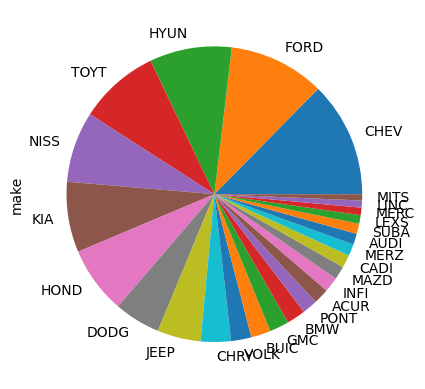

In [10]:
make_counts = df['make'].value_counts() # make a count of all the makes
make_keep = make_counts[make_counts >= 15].index # specify that we are keeping only makes that have 15 vehicles and over, to reduce visualization cluttering
df_makes = df[df['make'].isin(make_keep)] # creates a new dataframe with makes that have a count of 15 and over

df_makes["make"].value_counts().plot.pie()

In this pie chart that visualizes the distribution of towed vehicle makes, we can see that the most frequently towed vehicles are also generally the most best-selling car brands such as Chevy, Ford, Hyundai, Toyota, etc. However, even though Toyota is the top selling brand in America, Chevys and Fords tend to get towed more. This could be due to their inherent historic strength and prevalence in the Midwest. Luxury and high-end makes such as Mercedes, Lexus, Audi, etc are towed more infrequently likely because there are far fewer of them on the road.

# Visualization 5


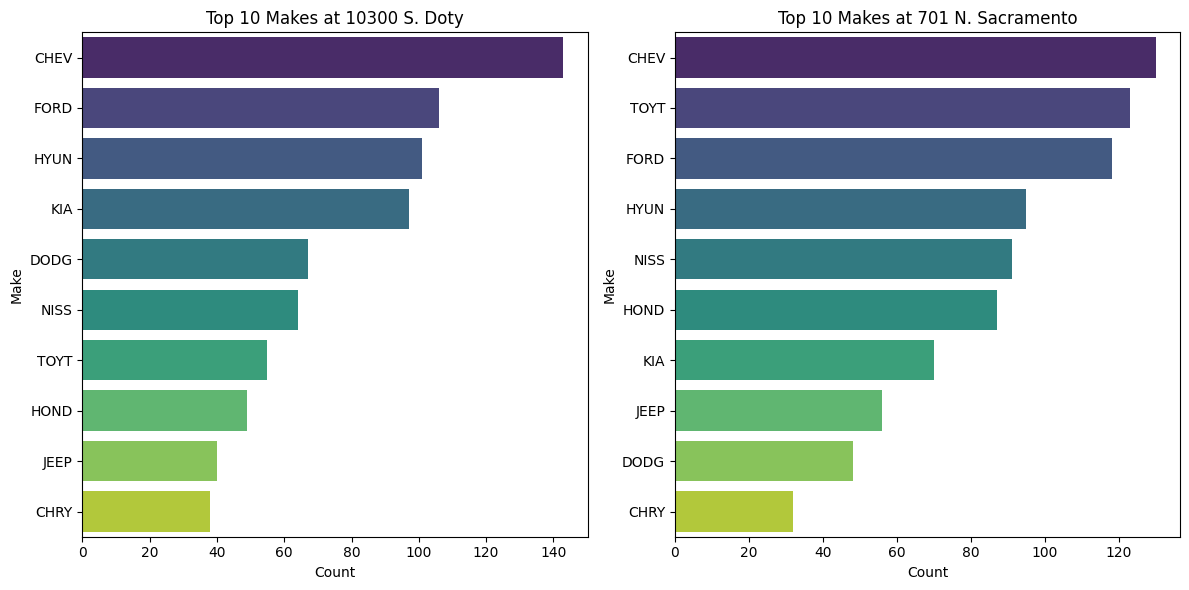

In [11]:
top_n = 10 # visualizing top 10 makes across 2 locations

location1 = '10300 S. Doty'
location2 = '701 N. Sacramento'

df_location1 = df[df['towed_to_address'] == location1]
df_location2 = df[df['towed_to_address'] == location2]

top_makes_location1 = df_location1['make'].value_counts().nlargest(top_n)
top_makes_location2 = df_location2['make'].value_counts().nlargest(top_n)

df_top_makes_location1 = top_makes_location1.reset_index()
df_top_makes_location2 = top_makes_location2.reset_index()
# renaming columns for clarity
df_top_makes_location1.columns = ['Make', 'Count']
df_top_makes_location2.columns = ['Make', 'Count']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=df_top_makes_location1, y='Make', x='Count', palette='viridis')
plt.title(f'Top {top_n} Makes at {location1}')

plt.subplot(1, 2, 2)
sns.barplot(data=df_top_makes_location2, y='Make', x='Count', palette='viridis')
plt.title(f'Top {top_n} Makes at {location2}')

plt.tight_layout()
plt.show()

In these bar graphs, we are comparing the top 10 makes that get towed the most frequently in 10300 S. Doty and 701 N. Sacramento. Comparing the two, we can see that Chevys are towed the most frequently across both locations. A notable difference between the two locations is that Toyotas are the 2nd most frequently towed make at 701 N. Sacramento while Toyotas are outside the top 5 frequent makes towed at 10300 S. Doty. This could mean there's a larger presence of Toyotas in the areas surrounding 701 N. Sacramento. Also, both graphs show Chrysler is the least towed make which could be interpreted as there's less sales of Chrysler compared to other car brands or possibly just less Chryslers in the area - potentially due to lack of dealerships or lack of interest in purchasing Chryslers.

# Visualization 6

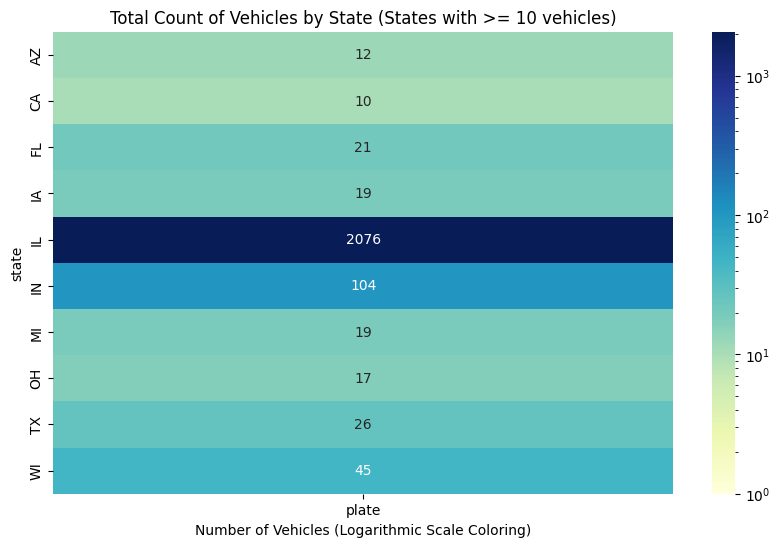

In [12]:
state_counts = df['state'].value_counts()
states_to_keep = state_counts[state_counts >= 10].index # Remove all states with less than 10 vehicles, to reduce visualization cluttering
filtered_df = df[df['state'].isin(states_to_keep)]

# Create a pivot table to count the number of vehicles per state
pivot_table = filtered_df.pivot_table(index='state', values='plate', aggfunc='count')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt="g", norm=LogNorm(vmin=1, vmax=pivot_table.values.max())) # Make the color scale logarithm so that the Illinois count doesn't skew the colors
plt.title('Total Count of Vehicles by State (States with >= 10 vehicles)')
plt.xlabel('Number of Vehicles (Logarithmic Scale Coloring)')
plt.show()

This heatmap is an alternative to a simple bar chart, and explores where vehicles that are towed in Chicago originate from (according to their license plates). As expected, the overwhelming majority are from Illinois, with the neighboring states of Indiana and Wisconsin coming in at second and third and other Midwestern states not far behind. There's also a noticable amount of California, Texas, and Florida plates, probably because they have very large populations.

# Visualization 7

In [13]:
# !pip install folium


In [14]:
# import folium

# # Create a map centered at a specific location
# m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)  # Chicago coordinates

# # Define the addresses and the number of vehicles towed
# data = [
#     {"address": "701 N. Sacramento", "vehicles": 1476},
#     {"address": "10300 S. Doty", "vehicles": 1376},
#     {"address": "400 E. Lower Wacker", "vehicles": 233},
#     {"address": "Chicago O'hare International Airport remote lot E.", "vehicles": 10},
# ]

# # Loop through the data and add markers to the map
# for entry in data:
#     address = entry["address"]
#     vehicles = entry["vehicles"]
#     tooltip = f"Address: {address}\nVehicles Towed: {vehicles}"
#     folium.Marker(location=geocode_address(address), tooltip=tooltip).add_to(m)

# # Coordinates of the addresses
# coordinates = [
#     (41.899178, -87.701065),  # 701 N. Sacramento
#     (41.705205, -87.595753),  # 10300 S. Doty
#     (41.884339, -87.614872),  # 400 E. Lower Wacker
#     (41.976129, -87.905576),  # Chicago O'hare International Airport remote lot E.
# ]

# # Calculate the center of the coordinates
# center = [sum([coord[0] for coord in coordinates]) / len(coordinates),
#           sum([coord[1] for coord in coordinates]) / len(coordinates)]
# # Display the map in the Jupyter Notebook
# m


In [15]:
# def geocode_address(address):
#     # This function should use a geocoding service to obtain actual coordinates for the address.
#     # For demonstration purposes, we are returning hardcoded coordinates for the example addresses.
#     coordinates = {
#         "701 N. Sacramento": [41.899178, -87.701065],
#         "10300 S. Doty": [41.705205, -87.595753],
#         "400 E. Lower Wacker": [41.884339, -87.614872],
#         "Chicago O'hare International Airport remote lot E.": [41.976129, -87.905576],
#     }
#     return coordinates.get(address, [0, 0])  # Return [0, 0] for unknown addresses

# # Use a real geocoding service for accurate coordinates in a production environment.
